# LIT-PCBA 
this dataset is a proposed "more difficult" test than DUD-E. I used a 75/25 (sklearn default) stratified split. The dataset is heavily imbalanced, like DUD-E.

In [1]:
import pickle
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import torch
import seaborn as sns
import pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt

# plt.rc('font', family='serif')
# plt.rc('xtick', labelsize='large')
# plt.rc('ytick', labelsize='large')
# plt.rc('text', usetex=True)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=17)
plt.rc('figure', titlesize=20)

In [2]:
def compute_enrichment_factor(scores, labels, n_percent):
    # this variant implements the equation from Xiaohua's paper
#     import pdb
#     pdb.set_trace()
    
    sample_n = int(np.ceil(n_percent * labels.shape[0]))
    
    
    
    sorted_scores = sorted(zip(scores, labels), key=lambda x: x[0], reverse=True)

    top_n_sorted_scores = sorted_scores[:sample_n]

    # counting number of true positives in top x% of sorted compounds
    actives_sampled = sum([y for x, y in top_n_sorted_scores])
    # labels are binary, sum to count number of actives
    actives_database = sum(labels)

    norm_factor = (sample_n/len(labels))

    return (actives_sampled / actives_database) * (labels.shape[0]/sample_n)


In [3]:
data_p = Path("/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results")

In [4]:
lit_pcba_path_list = [x for x in list(data_p.glob("lit_pcba.*.pkl")) if "lit_pcba_ave" not in x.parent.parent.name]
lit_pcba_path_list 

[PosixPath('/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba.PPARG.ecfp.atomwise.0.pkl'),
 PosixPath('/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba.ALDH1.ecfp.atomwise.0.pkl'),
 PosixPath('/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba.KAT2A.ecfp.atomwise.0.pkl'),
 PosixPath('/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba.MTORC1.ecfp.atomwise.0.pkl'),
 PosixPath('/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba.FEN1.ecfp.atomwise.0.pkl'),
 PosixPath('/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba.ESR1_ant.ecfp.atomwise.0.pkl'),
 PosixPath('/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba.ADRB2.ecfp.atomwise.0.pkl'),
 PosixPath('/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba.GBA.ecfp.atomwise.0.pkl'),
 PosixPath('/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba.PKM2.ecfp.atomwise.0.pkl'),
 PosixPath('/g/g13/

In [5]:
# import re

lit_pcba_target_names = list(set([x.name.split('.')[1] for x in lit_pcba_path_list]))
lit_pcba_target_names

['ALDH1',
 'ESR1_ago',
 'IDH1',
 'ESR1_ant',
 'GBA',
 'OPRK1',
 'ADRB2',
 'PKM2',
 'VDR',
 'FEN1',
 'MAPK1',
 'KAT2A',
 'PPARG',
 'TP53',
 'MTORC1']

In [6]:
def load_pkl(pkl_path, model, return_sizes=False):
    
    with open(pkl_path, "rb") as handle:
        data = pickle.load(handle) # lets just use one seed
        
        
        if 0 in data.keys():
            data = data[0]

        
        if "encode_time" not in data.keys():
            return
    
    if isinstance(data["y_true"], np.ndarray):
        y_true = data["y_true"]
    else:
        y_true = np.concatenate(data["y_true"]) 
    y_pred = np.array(data["y_pred"])

    
    eta = np.array(data["eta"])

    if np.unique(y_true).shape[0] < 2 :
        metric = 0
    else:
        metric = recall_score(y_pred=y_pred, y_true=y_true)
        if model in ["rf", "mlp"]:
            eta= eta[:, 1]

    print(pkl_path)
    if return_sizes:
        return y_true, y_pred, eta, metric, data["encode_time"], data["train_time"], data["test_time"], data["train_size"], data["test_size"]
    else:
        return y_true, y_pred, eta, metric, data["encode_time"], data["train_time"], data["test_time"]


# LIT-PCBA Results

In [7]:
# color_dict = {
#     "smiles-pe": "steelblue",
#     "ecfp": "lightcoral",
#     "rp": "seagreen",
#     "rf": "plum",
# #     "openhd": "green",
#     "mlp": "slateblue"
# }

# marker_dict = {
#     "smiles-pe": "+",
#     "ecfp": "+",
#     "rp": "+",
#     "rf": "^",
# #     "openhd": "*",
#     "mlp": "+"
# }


# 'smiles-pe.ngram.2', 'smiles-pe.ngram.3', 'rf', 'mlp'

color_dict = {
    "smiles-pe.atomwise.0": "steelblue",
    "smiles-pe.bpe.0": "steelblue",   
    "smiles-pe.ngram.1": "steelblue",
    "smiles-pe.ngram.2": "steelblue",
    "smiles-pe.ngram.3": "steelblue",
    "ecfp": "lightcoral",
    "rp": "seagreen",
    "rf": "plum",
#     "openhd": "green",
    "mlp": "slateblue"
}

marker_dict = {
    "smiles-pe.atomwise.0": "+",
    "smiles-pe.bpe.0": "+",   
    "smiles-pe.ngram.1": "+",
    "smiles-pe.ngram.2": "+",
    "smiles-pe.ngram.3": "+",
    "ecfp": "+",
    "rp": "+",
    "rf": "^",
#     "openhd": "*",
    "mlp": "+"
}


def aggregate_lit_pcba_results(dataset):
    
    model_metric_dict = {}
    
    
    enrich_1_f, enrich_1_ax = plt.subplots(1,1, figsize=(16,6))
    enrich_10_f, enrich_10_ax = plt.subplots(1,1, figsize=(16,6))

    
#     enrich_1_f.suptitle("Enrichment at 1\% of database")
#     enrich_10_f.suptitle("Enrichment at 10\% of database")
    
    
    f, ax = plt.subplots(1,2, figsize=(16,6))
    ax = ax.flatten()

    for model, color in color_dict.items():
        
        marker = marker_dict[model]
        
        model_metric_dict[model] = []
        
        metric_list = []
        encode_time_list = []
        train_time_list = []
        test_time_list = []
        eta_list = []
        
        
        
#         import pdb
#         pdb.set_trace()
        data_path_list = list(data_p.glob(f"{dataset}*.{model}*pkl"))
        
        train_size_list = []
        test_size_list = []
        target_size_list = []
        
        
        enrich_1_list = []
        enrich_10_list = []
        
        for path in data_path_list:
            
            target = path.stem.split(".")[1]
            print(target)
#             split = path.stem.split(".")[0].split("_")[-1]
            
            y_true, y_pred, eta, m, encode_time, train_time, test_time, train_size, test_size = load_pkl(path, model=model, return_sizes=True)
            
            if m is None:
                pass
            else:
                metric_list.append(m)
                encode_time_list.append(encode_time)
                train_time_list.append(train_time/10) # because i retrained 10 times
                test_time_list.append(test_time)
                eta_list.append(eta)
                train_size_list.append(train_size)
                test_size_list.append(test_size)
                
                enrich_1 = compute_enrichment_factor(scores=eta, labels=y_true, n_percent=.01)
                enrich_1_list.append(enrich_1)
                
                enrich_10 = compute_enrichment_factor(scores=eta, labels=y_true, n_percent=.1)
                enrich_10_list.append(enrich_10)

                target_size_list.append(train_size+test_size)
                
                model_metric_dict[model].append((m, enrich_1, enrich_10))
                
        sorted_metric_list = [x for _, x in sorted(zip(target_size_list, metric_list), key=lambda pair: pair[0])]
        sorted_encode_time_list = [x for _, x in sorted(zip(target_size_list, encode_time_list), key=lambda pair: pair[0])]
        sorted_train_time_list = [x for _, x in sorted(zip(target_size_list, train_time_list), key=lambda pair: pair[0])]
        sorted_test_time_list = [x for _, x in sorted(zip(target_size_list, test_time_list), key=lambda pair: pair[0])]
        sorted_enrich_1_list = [x for _, x in sorted(zip(target_size_list, enrich_1_list), key=lambda pair: pair[0])]
        sorted_enrich_10_list = [x for _, x in sorted(zip(target_size_list, enrich_10_list), key=lambda pair: pair[0])]
        sorted_train_size_list = sorted(train_size_list)
                
#         if model not in ["rf", "mlp"]:
#             sns.scatterplot(x=[x for x in range(len(target_size_list))], y=sorted_encode_time_list, ax=ax[1], color=color, marker=marker, label=model)
#         sns.scatterplot(x=[x for x in range(len(target_size_list))], y=sorted_train_time_list, ax=ax[2], color=color, marker=marker, label=model)


#     ax[0].set_ylabel("roc-auc-score")
#     ax[0].set_xlabel("DUD-E target")

#     plt.legend()
    return f, ax, enrich_1_f, enrich_1_ax, enrich_10_f, enrich_10_ax, model_metric_dict




PPARG
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba.PPARG.smiles-pe.atomwise.0.pkl
ALDH1
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba.ALDH1.smiles-pe.atomwise.0.pkl
KAT2A
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba.KAT2A.smiles-pe.atomwise.0.pkl
MTORC1
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba.MTORC1.smiles-pe.atomwise.0.pkl
FEN1
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba.FEN1.smiles-pe.atomwise.0.pkl
ESR1_ant
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba.ESR1_ant.smiles-pe.atomwise.0.pkl
ADRB2
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba.ADRB2.smiles-pe.atomwise.0.pkl
GBA
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba.GBA.smiles-pe.atomwise.0.pkl
PKM2
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba.PKM2.smiles-pe.atomwise.0.pkl
OPRK1
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdp

GBA
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba.GBA.ecfp.atomwise.0.pkl
PKM2
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba.PKM2.ecfp.atomwise.0.pkl
OPRK1
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba.OPRK1.ecfp.atomwise.0.pkl
TP53
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba.TP53.ecfp.atomwise.0.pkl
ESR1_ago
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba.ESR1_ago.ecfp.atomwise.0.pkl
VDR
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba.VDR.ecfp.atomwise.0.pkl
IDH1
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba.IDH1.ecfp.atomwise.0.pkl
MAPK1
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba.MAPK1.ecfp.atomwise.0.pkl
PPARG
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba.PPARG.rp.atomwise.0.pkl
ALDH1
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/lit_pcba.ALDH1.rp.atomwise.0.pkl
KAT2A
/g/g13

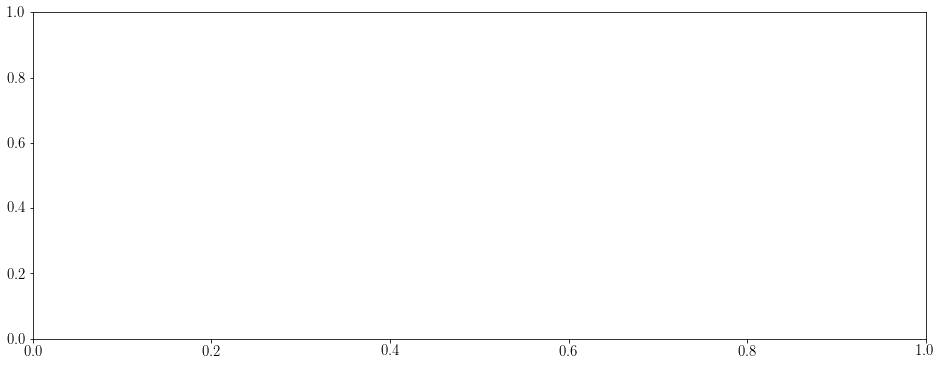

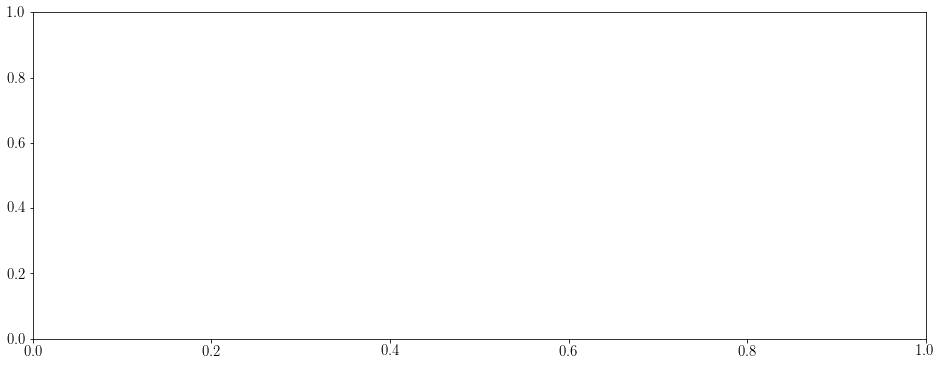

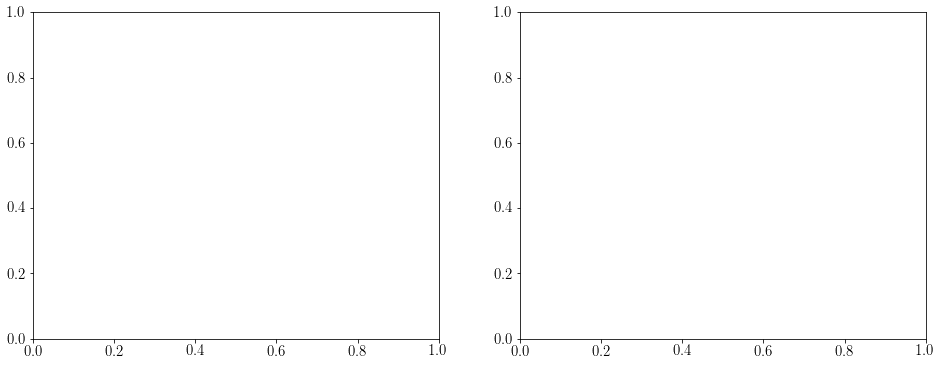

In [8]:
lit_pcba_f, lit_pcba_ax, lit_pcba_enrich_1_f, lit_pcba_enrich_1_ax, lit_pcba_enrich_10_f, lit_pcba_enrich_10_ax, model_metric_dict = aggregate_lit_pcba_results(dataset="lit_pcba")


In [9]:
print([len(x) for x in model_metric_dict.values()])
print([x for x in model_metric_dict.keys()])

[15, 15, 15, 15, 15, 15, 15, 15, 15]
['smiles-pe.atomwise.0', 'smiles-pe.bpe.0', 'smiles-pe.ngram.1', 'smiles-pe.ngram.2', 'smiles-pe.ngram.3', 'ecfp', 'rp', 'rf', 'mlp']


In [10]:
# 'smiles-pe.ngram.2', 'smiles-pe.ngram.3', 'rf', 'mlp'

In [11]:
# import pdb 
# pdb.set_trace()

model_metric_df = pd.DataFrame(model_metric_dict)
model_metric_df_list = [pd.DataFrame({"metric": [tup[0] for tup in model_metric_df[col].values], 
                                      "enrich-1": [tup[1] for tup in model_metric_df[col].values],
                                      "enrich-10": [tup[2] for tup in model_metric_df[col].values],
                                      "model": [col]*len(model_metric_df)}) for col in model_metric_df.columns]

model_metric_df = pd.concat(model_metric_df_list)
model_metric_df

,metric,enrich-1,enrich-10,model
0,0.000000,26.734694,5.714286,smiles-pe.atomwise.0
1,0.000000,1.338695,1.037775,smiles-pe.atomwise.0
2,0.000000,6.121466,1.224434,smiles-pe.atomwise.0
3,0.000000,0.000000,0.416566,smiles-pe.atomwise.0
4,0.000000,0.000000,0.869497,smiles-pe.atomwise.0
...,...,...,...,...
10,0.300000,28.963636,4.466355,mlp
11,0.000000,0.000000,0.000000,mlp
12,0.126697,38.447725,6.741930,mlp
13,0.000000,9.991391,3.999647,mlp


In [12]:
model_metric_df['enrich-1'] = model_metric_df['enrich-1'].apply(lambda x: float(np.array(x)))
model_metric_df['enrich-10'] = model_metric_df['enrich-10'].apply(lambda x: float(np.array(x)))

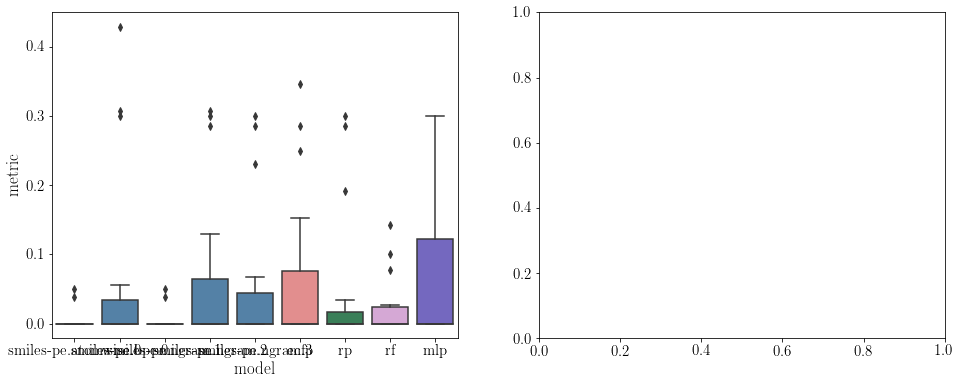

In [13]:
sns.boxplot(data=model_metric_df, x="model", y="metric", ax=lit_pcba_ax[0], palette=color_dict)
lit_pcba_f

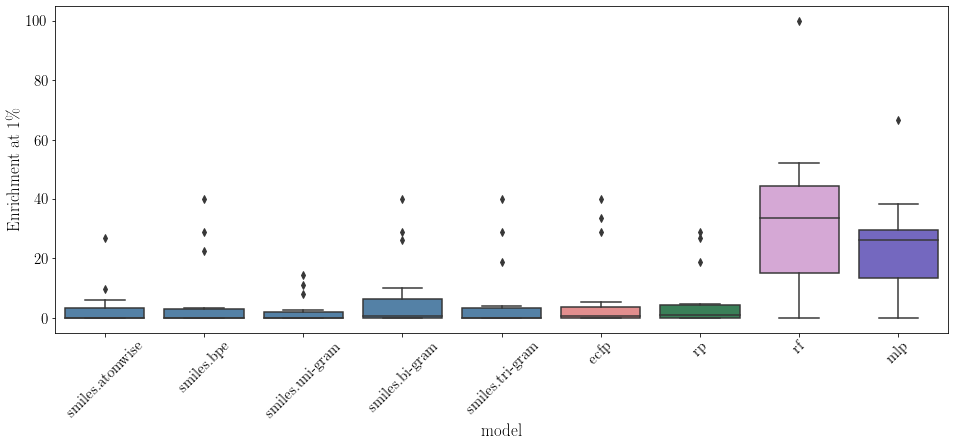

In [14]:
sns.boxplot(data=model_metric_df, x="model", y="enrich-1", ax=lit_pcba_enrich_1_ax, palette=color_dict)
# lit_pcba_enrich_1_ax.set_yscale("linear")
lit_pcba_enrich_1_ax.set_ylabel("Enrichment at 1\%")
lit_pcba_enrich_1_ax.tick_params(axis="x", labelrotation=45)
labels = [item.get_text() for item in lit_pcba_enrich_1_ax.get_xticklabels()]
labels[0] = "smiles.atomwise"
labels[1] = "smiles.bpe"
labels[2] = "smiles.uni-gram"
labels[3] = "smiles.bi-gram"
labels[4] = "smiles.tri-gram"
lit_pcba_enrich_1_ax.set_xticklabels(labels)
lit_pcba_enrich_1_f.savefig("lit_pcba_enrich_1.png", dpi=600, bbox_inches="tight")
lit_pcba_enrich_1_f

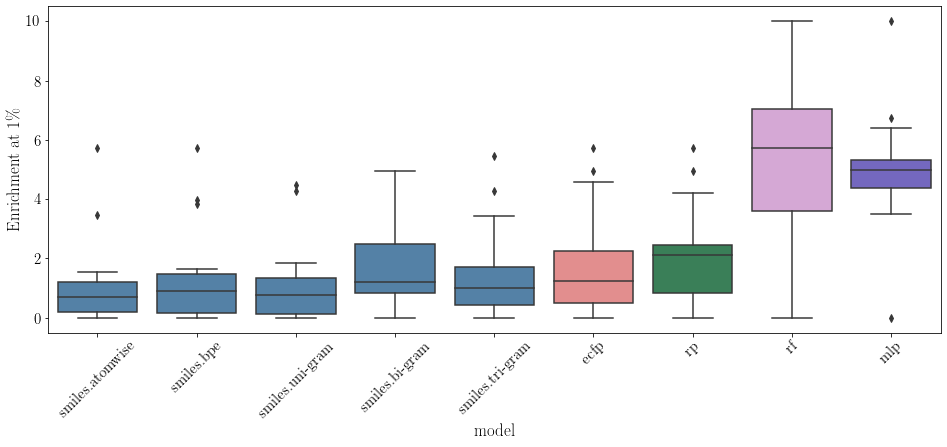

In [15]:
sns.boxplot(data=model_metric_df, x="model", y="enrich-10", ax=lit_pcba_enrich_10_ax, palette=color_dict)
lit_pcba_enrich_10_ax.set_ylabel("Enrichment at 1\%")
lit_pcba_enrich_10_ax.tick_params(axis="x", labelrotation=45)
labels = [item.get_text() for item in lit_pcba_enrich_10_ax.get_xticklabels()]
labels[0] = "smiles.atomwise"
labels[1] = "smiles.bpe"
labels[2] = "smiles.uni-gram"
labels[3] = "smiles.bi-gram"
labels[4] = "smiles.tri-gram"
lit_pcba_enrich_10_ax.set_xticklabels(labels)
lit_pcba_enrich_10_f.savefig("lit_pcba_enrich_10.png", dpi=600, bbox_inches="tight")
lit_pcba_enrich_10_f

In [16]:
model_metric_df[['enrich-1', 'enrich-10', 'model']].groupby("model").describe()

enrich-1                                        \
                        count       mean        std  min        25%   
model                                                                 
ecfp                     15.0   7.649219  13.990717  0.0   0.000000   
mlp                      15.0  23.873425  16.676006  0.0  13.266607   
rf                       15.0  32.288861  26.228586  0.0  15.206644   
rp                       15.0   5.891674  10.107685  0.0   0.000000   
smiles-pe.atomwise.0     15.0   3.401933   7.048207  0.0   0.000000   
smiles-pe.bpe.0          15.0   6.807744  12.771598  0.0   0.000000   
smiles-pe.ngram.1        15.0   2.579415   4.721129  0.0   0.000000   
smiles-pe.ngram.2        15.0   7.457792  13.119632  0.0   0.000000   
smiles-pe.ngram.3        15.0   6.510987  12.506802  0.0   0.000000   

                                                      enrich-10            \
                            50%        75%        max     count      mean   
model                                                                       
ecfp                   0.728955   3.763651  40.102041      15.0  1.812024   
mlp                   26.156805  29.425403  66.627160      15.0  4.962906   
rf                    33.630178  44.328039  99.940741      15.0  5.270183   
rp                     0.904652   4.334350  28.963636      15.0  2.136247   
smiles-pe.atomwise.0   0.000000   3.225322  26.734694      15.0  1.167224   
smiles-pe.bpe.0        0.000000   2.994617  40.102041      15.0  1.391411   
smiles-pe.ngram.1      0.000000   2.054216  14.481818      15.0  1.149145   
smiles-pe.ngram.2      0.728955   6.185449  40.102041      15.0  1.770074   
smiles-pe.ngram.3      0.000000   3.397467  40.102041      15.0  1.512836   

                                                                              
                           std  min       25%       50%       75%        max  
model                                                                         
ecfp                  1.857310  0.0  0.502394  1.224434  2.258074   5.714286  
mlp                   2.062881  0.0  4.376035  4.998791  5.305120  10.000000  
rf                    2.706669  0.0  3.612909  5.713900  7.045260  10.000000  
rp                    1.711636  0.0  0.828412  2.126649  2.445478   5.714286  
smiles-pe.atomwise.0  1.534987  0.0  0.208283  0.714237  1.223063   5.714286  
smiles-pe.bpe.0       1.737966  0.0  0.145981  0.908802  1.481850   5.714286  
smiles-pe.ngram.1     1.427252  0.0  0.129829  0.760810  1.330589   4.466355  
smiles-pe.ngram.2     1.614338  0.0  0.824528  1.190396  2.498810   4.962617  
smiles-pe.ngram.3     1.636834  0.0  0.443612  1.020361  1.702629   5.458879

# LIT-PCBA AVE-split

here we use the splits provided by the authors in order to test our method on a challenging benchmark

In [17]:
lit_pcba_ave_path_list = [x for x in list(data_p.glob("lit_pcba_ave*.pkl"))]
lit_pcba_ave_path_list 

[]

In [18]:
def aggregate_lit_pcba_ave_results(dataset, split=None):
    
    model_metric_dict = {}
    
    
    enrich_1_f, enrich_1_ax = plt.subplots(1,1, figsize=(16,6))
    enrich_10_f, enrich_10_ax = plt.subplots(1,1, figsize=(16,6))

    
    enrich_1_f.suptitle("Enrichment at 1\% of database")
    enrich_10_f.suptitle("Enrichment at 10\% of database")
    
    f, ax = plt.subplots(1,3, figsize=(16,6))
    ax = ax.flatten()

    for model, color in color_dict.items():
        
        marker = marker_dict[model]
        
        model_metric_dict[model] = []
        
        metric_list = []
        encode_time_list = []
        train_time_list = []
        test_time_list = []
        eta_list = []
        

        data_path_list = None
        data_path_list = list(data_p.glob(f"{dataset}*{model}.pkl"))
        
        
        
        
        
        train_size_list = []
        test_size_list = []
        target_size_list = []
        
        
        enrich_1_list = []
        enrich_10_list = []
        
        for path in data_path_list:
            
            target = path.stem.split("_")[1]
            split = path.stem.split(".")[0].split("_")[-1]
            
            y_true, y_pred, eta, m, encode_time, train_time, test_time, train_size, test_size = load_pkl(path, model=model, return_sizes=True)
            
            if m is None:
                pass
            else:
                metric_list.append(m)
                encode_time_list.append(encode_time)
                train_time_list.append(train_time/10) # because i retrained 10 times
                test_time_list.append(test_time)
                eta_list.append(eta)
                train_size_list.append(train_size)
                test_size_list.append(test_size)
                
                enrich_1 = compute_enrichment_factor(scores=eta, labels=y_true, n_percent=.01)
                enrich_1_list.append(enrich_1)
                
                enrich_10 = compute_enrichment_factor(scores=eta, labels=y_true, n_percent=.1)
                enrich_10_list.append(enrich_10)

                target_size_list.append(train_size+test_size)
                
                model_metric_dict[model].append((m, enrich_1, enrich_10))
                
        sorted_metric_list = [x for _, x in sorted(zip(target_size_list, metric_list), key=lambda pair: pair[0])]
        sorted_encode_time_list = [x for _, x in sorted(zip(target_size_list, encode_time_list), key=lambda pair: pair[0])]
        sorted_train_time_list = [x for _, x in sorted(zip(target_size_list, train_time_list), key=lambda pair: pair[0])]
        sorted_test_time_list = [x for _, x in sorted(zip(target_size_list, test_time_list), key=lambda pair: pair[0])]
        sorted_enrich_1_list = [x for _, x in sorted(zip(target_size_list, enrich_1_list), key=lambda pair: pair[0])]
        sorted_enrich_10_list = [x for _, x in sorted(zip(target_size_list, enrich_10_list), key=lambda pair: pair[0])]
        sorted_train_size_list = sorted(train_size_list)
                
        if model not in ["rf", "mlp"]:
            sns.scatterplot(x=[x for x in range(len(target_size_list))], y=sorted_encode_time_list, ax=ax[1], color=color, marker=marker, label=model)
        sns.scatterplot(x=[x for x in range(len(target_size_list))], y=sorted_train_time_list, ax=ax[2], color=color, marker=marker, label=model)


    ax[0].set_ylabel("roc-auc-score")
    ax[0].set_xlabel("DUD-E target")

    plt.legend()
    return f, ax, enrich_1_f, enrich_1_ax, enrich_10_f, enrich_10_ax, model_metric_dict

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


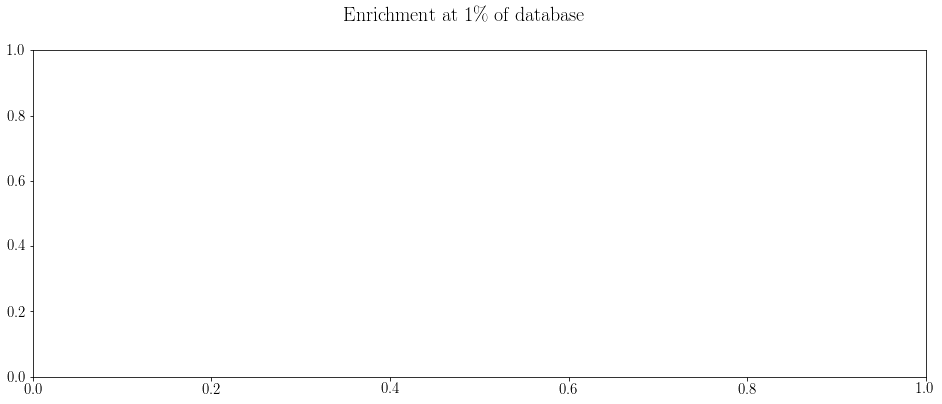

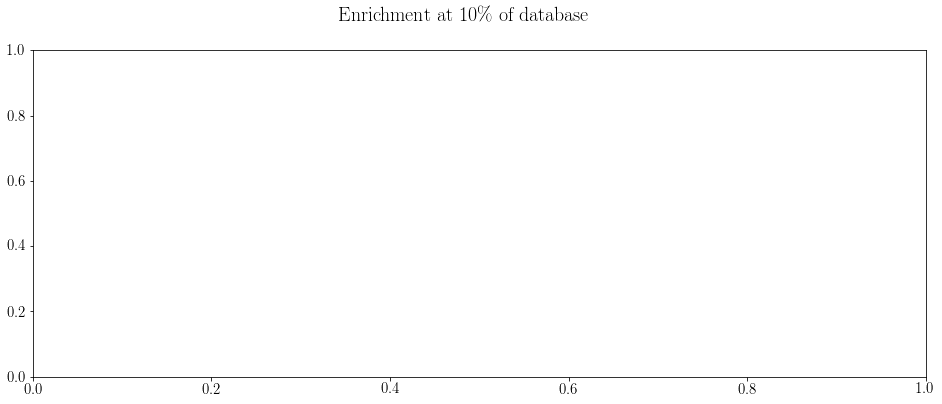

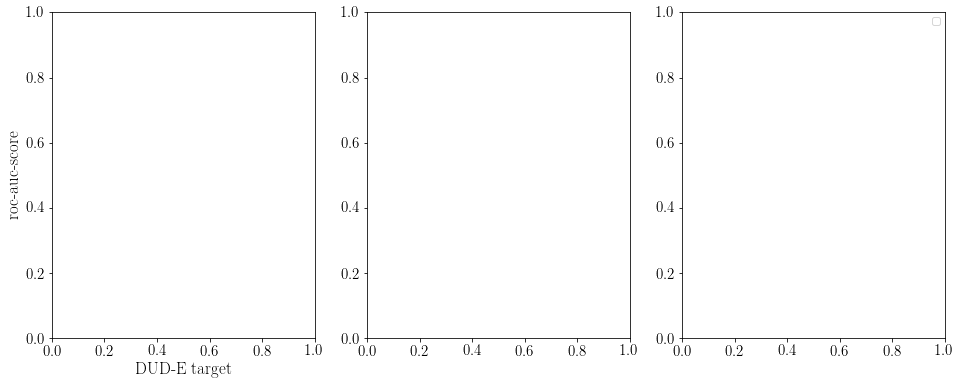

In [19]:
lit_pcba_ave_f, lit_pcba_ave_ax, lit_pcba_ave_enrich_1_f, lit_pcba_ave_enrich_1_ax, lit_pcba_ave_enrich_10_f, lit_pcba_ave_enrich_10_ax, lit_pcba_ave_model_metric_dict = aggregate_lit_pcba_ave_results(dataset="lit_pcba_ave")


In [20]:
lit_pcba_ave_model_metric_dict

{'smiles-pe.atomwise.0': [],
 'smiles-pe.bpe.0': [],
 'smiles-pe.ngram.1': [],
 'smiles-pe.ngram.2': [],
 'smiles-pe.ngram.3': [],
 'ecfp': [],
 'rp': [],
 'rf': [],
 'mlp': []}

In [21]:
[(key, len(value)) for key, value in lit_pcba_ave_model_metric_dict.items()]


[('smiles-pe.atomwise.0', 0),
 ('smiles-pe.bpe.0', 0),
 ('smiles-pe.ngram.1', 0),
 ('smiles-pe.ngram.2', 0),
 ('smiles-pe.ngram.3', 0),
 ('ecfp', 0),
 ('rp', 0),
 ('rf', 0),
 ('mlp', 0)]

In [22]:
# lit_pcba_ave_model_metric_dict = {key: value for key, value in lit_pcba_ave_model_metric_dict.items() if key not in ['smiles-pe', 'rp', 'rf']}
lit_pcba_ave_model_metric_dict = {key: value for key, value in lit_pcba_ave_model_metric_dict.items() if key not in ['rp']}

lit_pcba_ave_model_metric_dict
lit_pcba_ave_model_metric_df = pd.DataFrame(lit_pcba_ave_model_metric_dict)
lit_pcba_ave_model_metric_df.columns
lit_pcba_ave_model_metric_df_list = [pd.DataFrame({"metric": [tup[0] for tup in lit_pcba_ave_model_metric_df[col].values],
                                      "enrich-1": [tup[1] for tup in lit_pcba_ave_model_metric_df[col].values],
                                      "enrich-10": [tup[2] for tup in lit_pcba_ave_model_metric_df[col].values],
                                      "model": [col]*len(lit_pcba_ave_model_metric_df)}) for col in lit_pcba_ave_model_metric_df.columns]

lit_pcba_ave_model_metric_df = pd.concat(lit_pcba_ave_model_metric_df_list)
lit_pcba_ave_model_metric_df

,metric,enrich-1,enrich-10,model


In [23]:
sns.boxplot(data=lit_pcba_ave_model_metric_df, x="model", y="enrich-1", ax=lit_pcba_ave_enrich_1_ax, palette=color_dict)
lit_pcba_ave_enrich_1_f

ValueError: min() arg is an empty sequence

In [ ]:
lit_pcba_ave_model_metric_df

In [ ]:
sns.boxplot(data=lit_pcba_ave_model_metric_df, x="model", y="enrich-10", ax=lit_pcba_ave_enrich_10_ax, palette=color_dict)
lit_pcba_ave_enrich_10_f